## 基础概念
&emsp;&emsp;超参数(参数的参数,每次改变超参数,模型都要重新训练)是在模型训练之前设置值的参数,其值不能通过训练过程得到.通常情况下,在模型训练过程中需要对
超参数进行优化,给训练器(模型)选择一组最优的超参数,以提高训练器的性能和效果.比如,树的数量或树的深度,学习率(多种模式),以及k均值
聚类中的簇数等都是超参数.   
&emsp;&emsp;与超参数区别的概念是参数,参数的值通过训练器学习得出,比如回归系数,神经网络权重等.

* 为了评价每次挑选的超参数组合的好坏,需要选择合适评价指标,评价指标可以根据自己的需要选择accuracy、f1-score、f-beta、percision、recall等
* 为了避免数据的划分对评价结果产生影响,需要采用k折交叉验证的方式来减少偶然性造成的误差

常见的超参数搜索算法有:
1. 网格搜索
2. 随机搜索
3. 贝叶斯超参数优化

## 网格搜索
* 网格搜索通过穷举法列出不同的超参数组合(某组超参数值域的笛卡尔集为一组超参数网格),搜索算法使用不同的超参数组合训练模型并挑选验证误差最小的超参数组合(暴力搜索)

## 随机搜索(并行;优于网格搜索)

1. 对于搜索范围是distribution的超参数,根据给定的distribution随机采样

2. 对于搜索范围是array_like的超参数,在给定的array_like中等概率采样

3. 对a、b两步中得到的n_iter组采样结果,进行遍历
    * 如果给定的搜索范围均为array_like,则不放回抽样n_iter次

4. 当评估结果没有什么进展时,可以进行早停

#### 随机搜索有效性解释

<img src="../../../Other/img/随机搜索.jpg" style="width:500px;height:300px;float:bottom">

* 目标函数为$f(x,y)=g(x)+h(y)$,其中绿色为$g(x)$,黄色为$h(y)$,目标是求$f$的最大值

* 其中由于$g(x)$数值上要明显大于$h(y)$,因此有$f(x,y)=g(x)+h(y)≈g(x)$,也就是说在整体求解$f(x,y)$最大值的过程中,$g(x)$的影响明显大于$h(y)$

* 两个图都进行9次实验(搜索),可以看到左图实际探索了各三个点(在横轴和纵轴上的投影均为3个),而右图随机探索了9个不同的点

* 可以看出,右图更可能找到目标函数的最大值

## 贝叶斯超参数优化

贝叶斯优化算法在寻找最优最值参数时,采用了与网格搜索、随机搜索完全不同的方法.
网格搜索和随机搜索在测试一个新点时,会忽略前一个点的信息;而贝叶斯优化算法则充分利用了之前的信息.
贝叶斯优化算法通过对目标函数形状进行学习,找到使目标函数向全局最优值提升的参数.
具体来说,它学习目标函数形状的方法是,首先根据先验分布,假设一个搜集函数;然后,每一次使用新的采样点来测试目标函数时,利用这个信息来更新目标函数的先验分布;
最后,算法测试由后验分布给出的全局最值最可能出现的位置的点.
对于贝叶斯优化算法,有一个需要注意的地方,一旦找到了一个局部最优值,它会在该区域不断采样,所以很容易陷入局部最优值.
为了弥补这个缺陷，贝叶斯优化算法会在探索和利用之间找到一个平衡点,"探索"就是在还未取样的区域获取采样点;而"利用"则是根据后验分布在最可能出现全局最值的区域进行采样

Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize.
As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

In [24]:
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

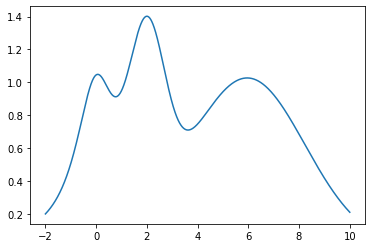

In [25]:
# 目标函数及其可视化
def target(x):
    return np.exp(-(x - 2) ** 2) + np.exp(-(x - 6) ** 2 / 10) + 1 / (x ** 2 + 1)


x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [26]:
optimizer = BayesianOptimization(target, {'x': (-2, 10)}, random_state=27)

In [27]:
# 进行5次随机探索
optimizer.maximize(init_points=5, n_iter=0)

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  0.8198   |  3.109    |
|  2        |  0.746    |  7.775    |
|  3        |  0.9553   |  6.825    |
|  4        |  0.5717   |  8.416    |
|  5        |  1.141    |  2.601    |


In [28]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma


def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)  # 优化搜索次数
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size': 30}
    )

    axis = fig.add_subplot(1, 1, 1)

    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)

    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]),
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
              alpha=.6, fc='c', ec='None', label='95% confidence interval')

    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size': 20})
    axis.set_xlabel('x', fontdict={'size': 20})
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

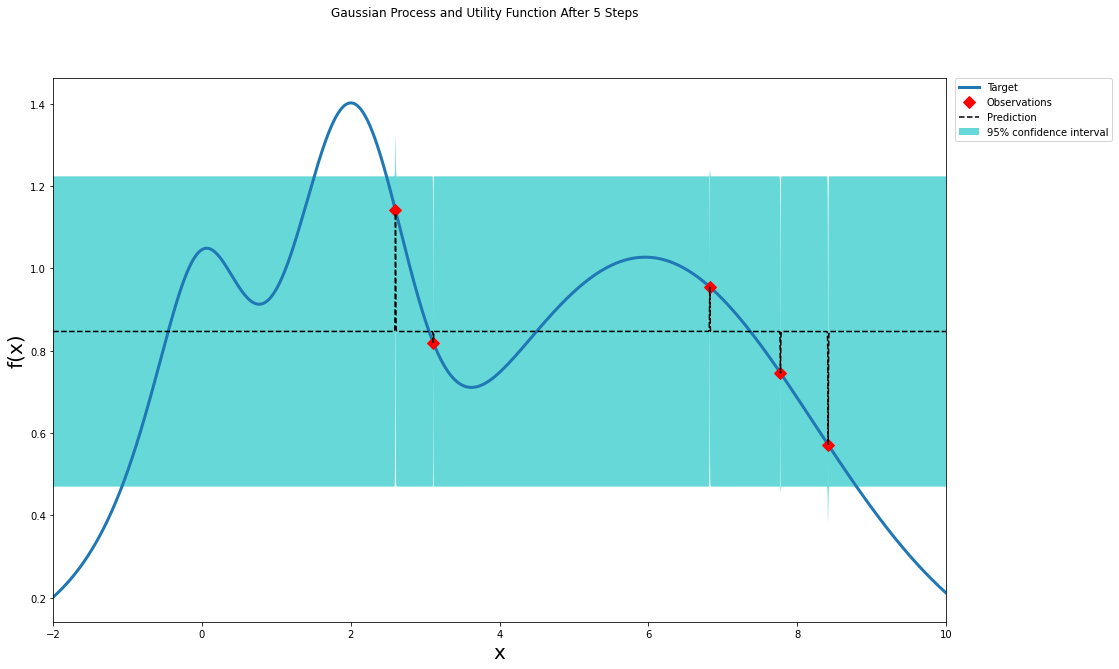

In [29]:
# 5次随机搜索的结果
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
|  6        |  1.143    |  2.597    |
|  7        |  1.393    |  1.899    |
|  8        |  0.9176   |  0.6829   |


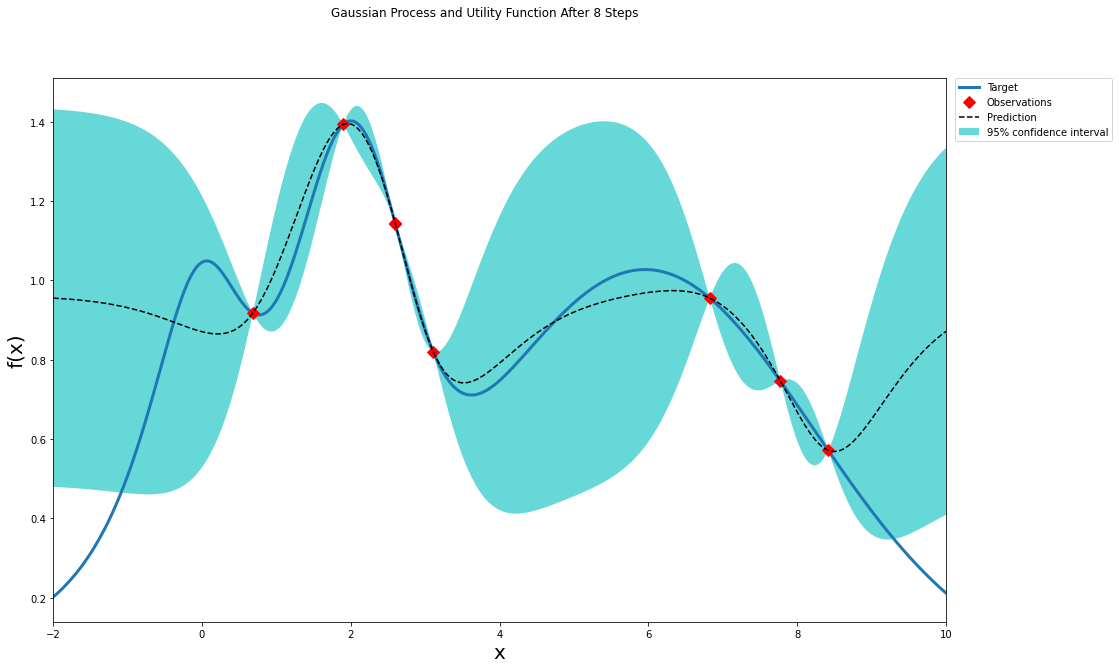

In [30]:
# 3次贝叶斯搜索的结果(已经验证的点置信区间为0)
optimizer.maximize(init_points=0, n_iter=3)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
|  9        |  0.2017   | -2.0      |
|  10       |  0.9925   |  5.351    |
|  11       |  1.244    |  1.543    |


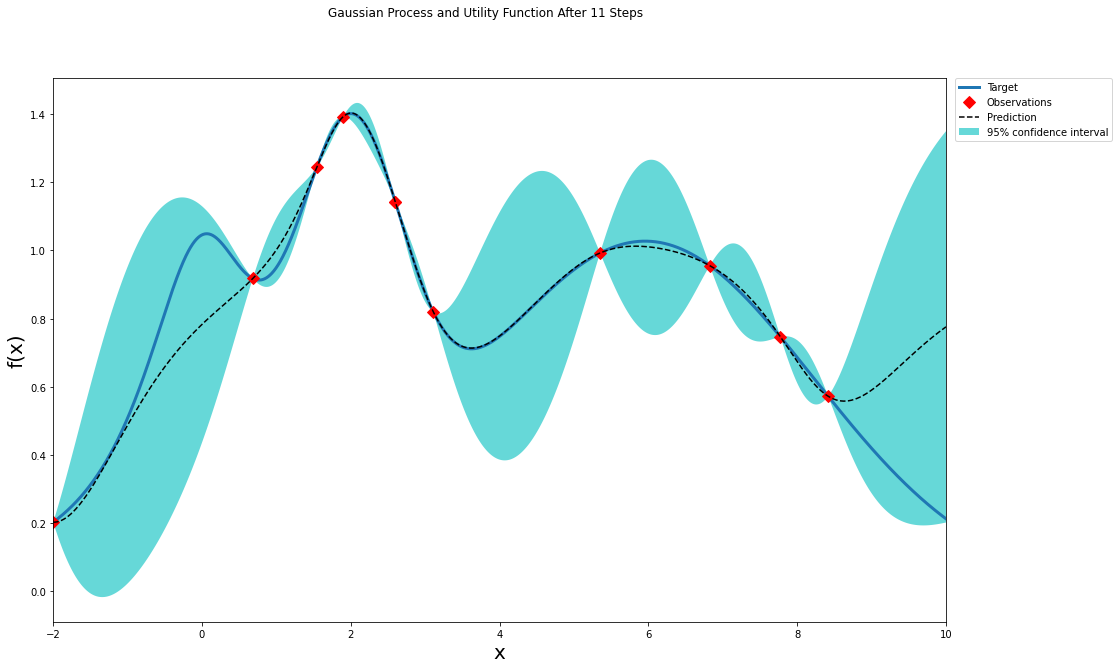

In [31]:
# 6次贝叶斯抖索的结果
optimizer.maximize(init_points=0, n_iter=3)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
|  12       |  0.2119   |  10.0     |
|  13       |  1.394    |  2.098    |
|  14       |  1.402    |  1.999    |


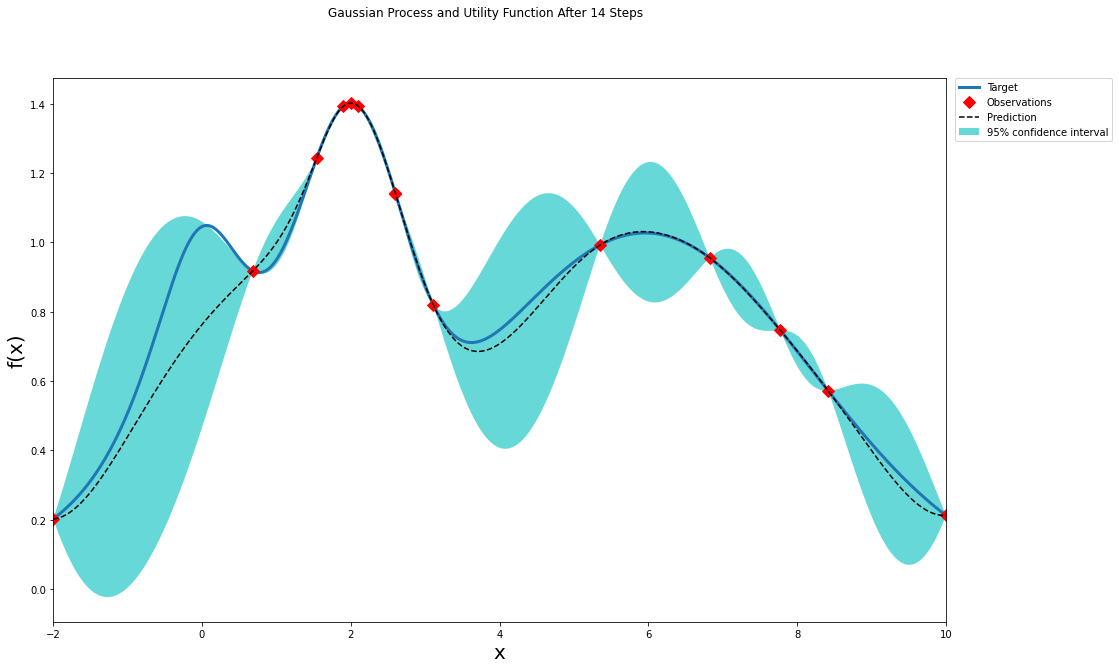

In [32]:
# 9次贝叶斯搜索的结果
# 探索未知区域(置信区间较大)和当前结果较好地方的一种均衡
optimizer.maximize(init_points=0, n_iter=3)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
|  15       |  1.402    |  2.001    |
|  16       |  1.402    |  2.001    |
|  17       |  1.402    |  2.0      |


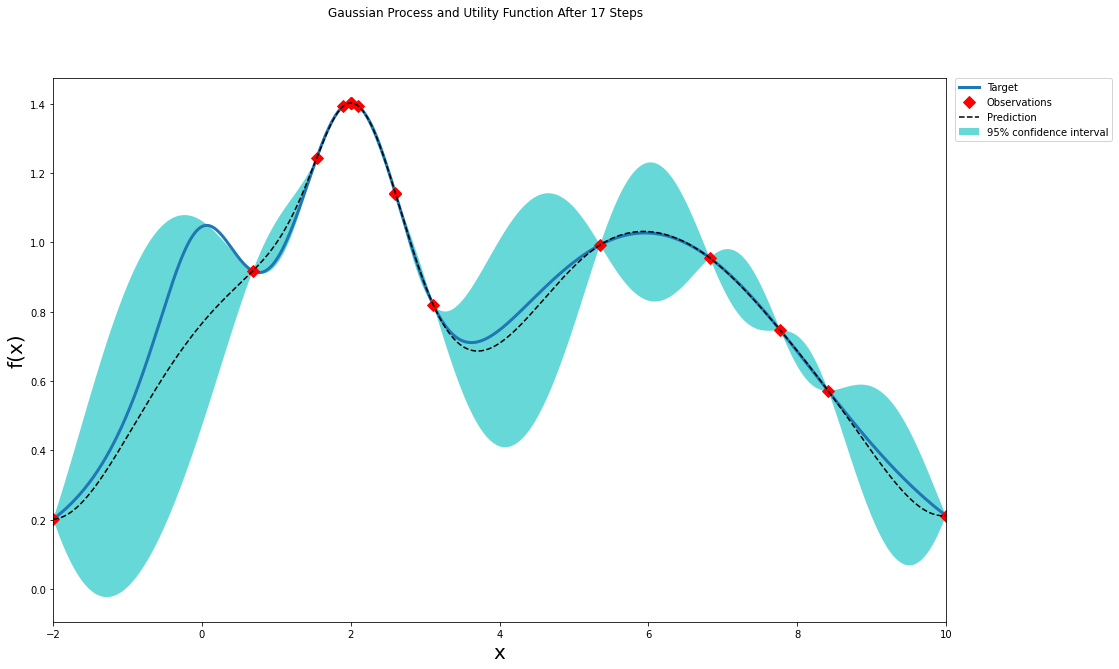

In [33]:
# 12次贝叶斯搜索的结果
optimizer.maximize(init_points=0, n_iter=3)
plot_gp(optimizer, x, y)

|   iter    |  target   |     x     |
-------------------------------------
|  18       |  1.402    |  2.001    |
|  19       |  1.402    |  2.001    |
|  20       |  1.402    |  1.999    |
|  21       |  1.402    |  1.999    |
|  22       |  1.402    |  2.002    |
|  23       |  1.402    |  1.998    |
|  24       |  1.402    |  2.003    |
|  25       |  1.402    |  1.996    |
|  26       |  1.402    |  2.007    |
|  27       |  1.402    |  1.993    |
|  28       |  1.402    |  2.007    |
|  29       |  1.402    |  1.992    |
|  30       |  1.402    |  2.006    |
|  31       |  1.402    |  1.995    |
|  32       |  1.402    |  2.007    |
|  33       |  1.402    |  1.995    |
|  34       |  1.402    |  2.007    |
|  35       |  1.402    |  1.994    |
|  36       |  1.402    |  2.006    |
|  37       |  1.402    |  1.995    |


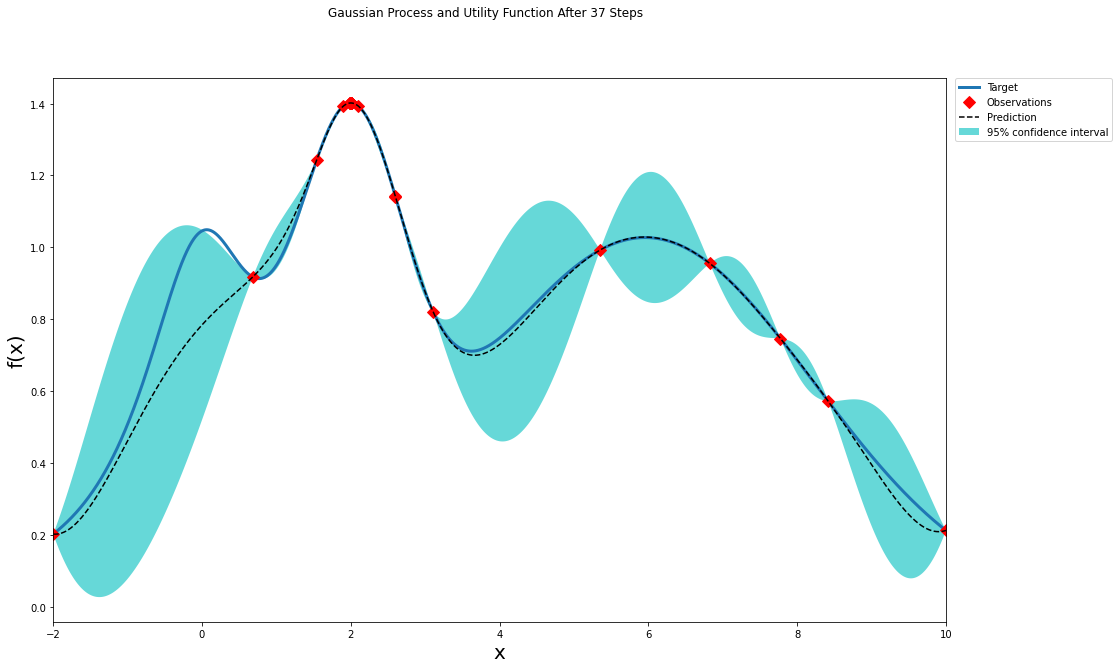

In [34]:
# 32次贝叶斯搜索的结果
optimizer.maximize(init_points=0, n_iter=20)
plot_gp(optimizer, x, y)